# Using TextBlob and Vader as Out of the Box Analysers

This notebook uses two 'Out of the Box' or Rules-based sentiment analysers, TextBlob and Vader to determine the sentiment of the training set reviews. The analyser is not learning anything, it is simply treating each review separately and comparing it to a set of rules. The data can be fed raw into the analyser (although cleaning can be used first) and does not need the extensive cleaning of machine learning models, which make them very easy and quick to use.

* Section 1 - import libraries and dataset
* Section 2 - Pre-processing

* Section 2 - analyser performance against sample phrases  
* Section 3 - TextBlob and VADER 
* Section 4 - Comparison of analyser scores with user scores
* Section 5 - VADER scores compared to review length
* Section 6 - Rerunning results with cleaned review text
* Section 7 - Summary

*Note: Rating refers to the user rating and score is the binary score allocated - with 1 referring to the majority class of positive reviews and -1 relating to the minority class of negative reviews.*

Data needed to run notebook:

* sampled_data.csv
* cleanedsampletext.csv

# Section 1: Import libraries and Dataset

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import nltk
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import nltk
from sklearn.metrics import f1_score,precision_score,recall_score,accuracy_score, roc_auc_score
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('sampled_data.csv',index_col = 0)

In [3]:
df.head(2)

,Name,Category,Town,Type,Contributions,Title,Review,Rating,Date,LocCode,Cuisine,Score
0,Motte & Bailey,Food,Arundel,Café,21,Excellent Breakfasts,Whether it was the full English or poached egg...,5,2.0,0.0,Other,0
1,Carlton Hotel,Accommodation,Bognor,B&B/Inn,87,Won't be returning,Stayed here for one night for work. Check in a...,2,4.0,2.0,0,1


In [4]:
# Function to select columns of interest, join title and review, drop unwanted columns and reset index
def proc(df):
    df = df[["Town","Category","Title","Review","Score"]]
    df["all_text"] = df["Title"] +" "+ df["Review"]
    df.drop(columns = ["Title","Review"],axis = 1, inplace = True)
    df.columns = ["Town","Category","Score","all_text"]
    return df

In [5]:
df = proc(df)

In [6]:
df.head()

,Town,Category,Score,all_text
0,Arundel,Food,0,Excellent Breakfasts Whether it was the full E...
1,Bognor,Accommodation,1,Won't be returning Stayed here for one night f...
2,Bognor,Food,1,Christmas lunch Sadly it’s not as good as it u...
3,Arundel,Food,0,The Pub that can! On saturday night we held a ...
4,Arundel,Food,1,Very disappointing experience Kept my husband ...


# Section 2: Preprocessing

In [7]:
# Put bad reviews as -1 and good reviews as 1
df.Score.replace(1, -1, inplace = True)
df.Score.replace(0, 1, inplace = True)

In [8]:
# Compare numbers of positive and negative reviews
df.Score.value_counts()

-1    1301
 1    1301
Name: Score, dtype: int64

# Section 3: Testing TextBlob and Vader Against Sample Phrases

In [9]:
# Set up an analyser object for Vader
sia = SentimentIntensityAnalyzer()

In [10]:
# Results function
def pol(text):
    pol1 = TextBlob(text).sentiment.polarity
    pol2 = sia.polarity_scores(text)['compound']
    return pol1, pol2, 

## Capitalisation

In [11]:
# Capitalisation of a word
t1 = "This is the worst restaurant I have ever eaten in"
t2 = "This is the WORST restaurant I have ever eaten in"

In [12]:
sent_1 = pol(t1)
sent_2 = pol(t2)
data1 = pd.DataFrame([sent_1,sent_2],index = ["S1","S2"],columns = ["TextBlob","Vader"])
data1.T

,S1,S2
TextBlob,-1.0000,-1.0000
Vader,-0.6249,-0.7034


* Both analysers are negative but only Vader picks up the intensity of capitalisation

## Word Strength

In [13]:
# Word Strength
t3 = "The food is good"
t4 = "The food is great"
t5 = "The food is incredible"
t6 = "The food is awesome"

In [14]:
sent_3 = pol(t3)
sent_4 = pol(t4)
sent_5 = pol(t5)
sent_6 = pol(t6)
data2 = pd.DataFrame([sent_3,sent_4,sent_5,sent_6],index = ["S3","S4","S5","S6"],columns = ["TextBlob","Vader"])
data2.T

,S3,S4,S5,S6
TextBlob,0.7000,0.8000,0.9,1.0000
Vader,0.4404,0.6249,0.0,0.6249


* TextBlob picks up the increasing intensity of words more effectively than Vader 

## Promotor Words

In [15]:
# Promotor words - modulate intensity
t7 = "The food is good"
t8 = "The food is very good"
t9 = "The food is very very good"

In [16]:
sent_7 = pol(t7)
sent_8 = pol(t8)
sent_9 = pol(t9)
data3 = pd.DataFrame([sent_7,sent_8,sent_9],index = ["S7","S8","S9"],columns = ["TextBlob","Vader"])
data3.T

,S7,S8,S9
TextBlob,0.7000,0.9100,0.9100
Vader,0.4404,0.4927,0.5379


* TextBlob picks up increased instensity from the use of the word 'very'
* Vader picks up the increased intensity from repeated words also

## Double Negation

In [17]:
# Double Negation
t10 = "This is not the worst place in the town, not by any means"

In [18]:
sent_10 = pol(t10)
data4 = pd.DataFrame([sent_10],index = ["S10"],columns = ["TextBlob","Vader"])
data4.T

,S10
TextBlob,-1.0000
Vader,0.5096


* Vader picks up that the review is positive and not negative

## Adjectives

In [19]:
# Adjectives
t11 = "The restaurant is worth visiting"
t12 = "The restaurant is hardly worth visiting"

In [20]:
sent_11 = pol(t11)
sent_12 = pol(t12)
data5 = pd.DataFrame([sent_11,sent_12],index = ["S11","S12"],columns = ["TextBlob","Vader"])
data5.T

,S11,S12
TextBlob,0.3000,0.3000
Vader,0.2263,0.1548


* Vader adjusts the score downwards for the word 'hardly'.

## Punctuation

In [21]:
# Punctuation
t13 = "The food is great"
t14 = "The food is great!"
t15 = "The food is great!!"

In [22]:
sent_13 = pol(t13)
sent_14 = pol(t14)
sent_15 = pol(t15)
data6 = pd.DataFrame([sent_13,sent_14,sent_15],index = ["S13","S14","S15"],columns = ["TextBlob","Vader"])
data6.T

,S13,S14,S15
TextBlob,0.8000,1.0000,1.0000
Vader,0.6249,0.6588,0.6892


* VADER picks up the second exclamation mark.

## Intent

In [23]:
# Intent (sarcasm)
t16 = "Is this the best restaurant in town??"

In [24]:
sent_16 = pol(t16)
data7 = pd.DataFrame([sent_16],index = ["S16"],columns = ["TextBlob","Vader"])
data7.T

,S16
TextBlob,1.0000
Vader,0.6767


* Both analysers return positive to a negative sentiment but Vader does have a lower score

## Contrast

In [25]:
# Mixed sentences - contrast
t17 = "The view is amazing but the food is awful"
t18 = "I loved this place, however it could do with a refurbishment"

In [26]:
sent_17 = pol(t17)
sent_18 = pol(t18)
data8 = pd.DataFrame([sent_17,sent_18],index = ["S17","S18"],columns = ["TextBlob","Vader"])
data8.T

,S17,S18
TextBlob,-0.2000,0.7000
Vader,-0.3818,0.5994


* Both analysers swap from negative to positive between the two sentences.

## Context - ambiguous adjectives and one word, many meanings

In [27]:
# Context - ambiguous adjectives - convey perspective
t19 = "The food is pretty good"
t20 = "The food is pretty bad"

# One word with many meanings (low can be seen as negative but in context of prices it isnt)
t21 = "The prices are high"
t22 = "The prices are low"

In [28]:
sent_19 = pol(t19)
sent_20 = pol(t20)
sent_21 = pol(t21)
sent_22 = pol(t22)
data9 = pd.DataFrame([sent_19,sent_20,sent_21,sent_22],index = ["S19","S20","S21","S22"],columns = ["TextBlob","Vader"])
data9.T

,S19,S20,S21,S22
TextBlob,0.4750,-0.2250,0.16,0.0000
Vader,0.7269,-0.0772,0.00,-0.2732


* Both analysers deal with the first two sentences 

## Emojis

In [29]:
t23 = "Love this place"
t24 = "Love this place :)"
sent_23 = pol(t23)
sent_24 = pol(t24)

In [30]:
data10 = pd.DataFrame([sent_23,sent_24],index = ["S23","S24"],columns = ["TextBlob","Vader"])
data10.T

,S23,S24
TextBlob,0.5000,0.500
Vader,0.6369,0.802


# Section 4: Passing All Reviews Through TextBlob and Vader

## TextBlob

In [31]:
# Run TextBlob against each review in the dataframe
df["Polarity"] = df["all_text"].apply(lambda x: TextBlob(x).sentiment.polarity)
df["Subjectivity"] = df["all_text"].apply(lambda x: TextBlob(x).sentiment.subjectivity)

In [32]:
# Check basic descriptive statistics
df.describe()

,Score,Polarity,Subjectivity
count,2602.000000,2602.000000,2602.000000
mean,0.000000,0.159195,0.556086
std,1.000192,0.272254,0.123231
min,-1.000000,-1.000000,0.111111
25%,-1.000000,-0.033333,0.475201
50%,0.000000,0.169444,0.550000
75%,1.000000,0.365078,0.634187
max,1.000000,1.000000,1.000000


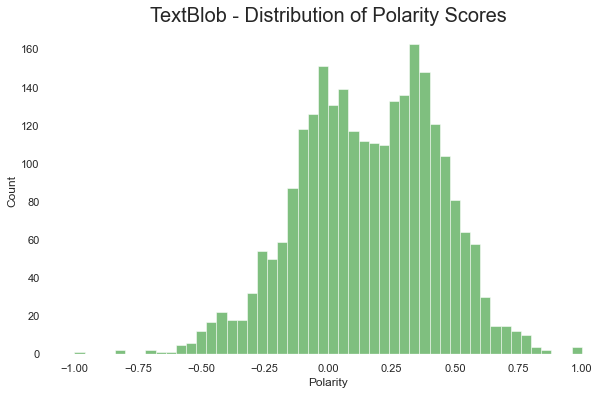

In [33]:
# Look at how the Polarity scores are distributed - TextBlob
num_bins = 50

fig, ax = plt.subplots(figsize=(10,6))
ax.set_facecolor("White")
n, bins, patches = plt.hist(df.Polarity, num_bins, facecolor='green', alpha=0.5)
plt.xlabel('Polarity')
plt.ylabel('Count')
plt.title('TextBlob - Distribution of Polarity Scores',size = 20)
plt.show();

In [34]:
# How many reviews have positive, neutral and negative sentiment according to TextBlob?
print(df[df["Polarity"] > 0].shape[0])
print(df[(df["Polarity"] == 0) & (df["Polarity"]<0.01)].shape[0])
print(df[df["Polarity"] <0].shape[0])

1816
4
782


Most are rated positive, there are very few neutral as we would expect as the sample data set had reviews rated '3' stripped out, leaving the most highly rated and lowest rated reviews in the dataset. The distribution appears bimodal.

In [35]:
# Get skew - small negative skew
df.Polarity.skew()

-0.2028473583026537

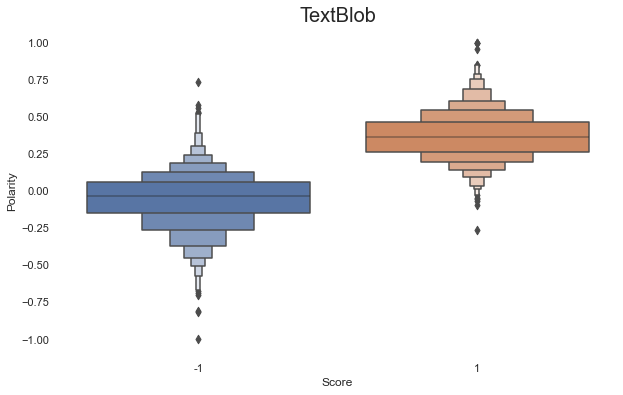

In [36]:
# Look at the Distribution of Polarity with regard to Ratings
fig, ax = plt.subplots(figsize = (10,6))
ax.set_facecolor("White")
sns.boxenplot(x='Score', y='Polarity', data=df)
plt.title("TextBlob",fontsize = 20)
plt.show();

## VADER

In [37]:
# Run VADER against each review in the dataframe
df["VNeg"] = df["all_text"].apply(lambda x: sia.polarity_scores(x)['neg'])
df["VNeu"] = df["all_text"].apply(lambda x: sia.polarity_scores(x)['neu'])
df["VPos"] = df["all_text"].apply(lambda x: sia.polarity_scores(x)['pos'])
df["VComp"] = df["all_text"].apply(lambda x: sia.polarity_scores(x)['compound'])

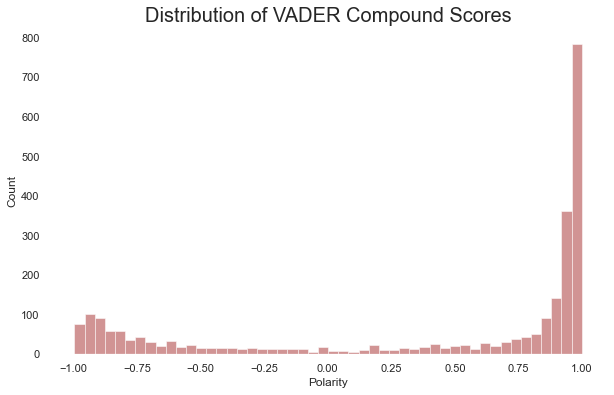

In [38]:
# Plot Vader Compound Scores
num_bins = 50
fig, ax = plt.subplots(figsize=(10,6))
ax.set_facecolor("White")
n, bins, patches = plt.hist(df.VComp, num_bins, facecolor='brown', alpha=0.5)
plt.xlabel('Polarity')
plt.ylabel('Count')
plt.title('Distribution of VADER Compound Scores', fontsize = 20)
plt.show();

In [39]:
# How many reviews have sentiment above and below 0.05 threshold suggested in the documentation
print(df[df["VComp"] >= 0.05].shape[0])
print(df[(df["VComp"] <0.05) & (df["VComp"] > -0.05)].shape[0])
print(df[df["VComp"] <= -0.05].shape[0])

1812
28
762


Vader has a few more neutrals, probably because the threshold scores are a bit different as per the documentation. The distribution of polarities is very different however.

In [40]:
# Get skew of VComp distribution
df.VComp.skew()

-0.8318932659576479

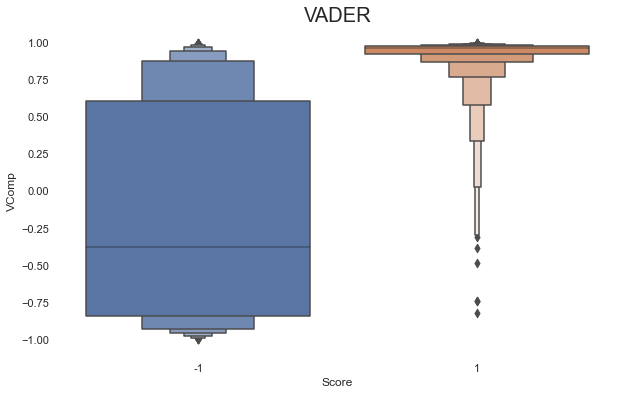

In [41]:
# Look at the Distribution of Polarity with regard to Ratings
fig, ax = plt.subplots(figsize = (10,6))
ax.set_facecolor("White")
sns.boxenplot(x='Score', y='VComp', data=df)
plt.title("VADER",fontsize = 20)
plt.show();

* TextBlob scores are slightly negatively skewed with bimodal distribution
* VADER's distribution is negatively skewed with a unimodal distribution
* VADER scores most reviews as strongly positive and there are outliers.  
* The boxplot for VADER shows greater variation in the compound polarity for negative reviews compared to positive. 

# Section 4: Comparison of Analyser Scores with User Rating

## TextBlob

Uses a weighted average score over all the words in a sentence

In [42]:
# Check for any polaritiy scores that are zero or neutral sentiment
df[df["Polarity"] == 0]

,Town,Category,Score,all_text,Polarity,Subjectivity,VNeg,VNeu,VPos,VComp
690,Arundel,Food,-1,I think you have to announce your arrival ... ...,0.0,0.4,0.113,0.835,0.051,-0.5046
1219,Arundel,Food,-1,A Miss Evening dinner disaster.\nLost our rese...,0.0,0.7,0.341,0.659,0.000,-0.9097
1353,Arundel,Food,1,Yummy Sunday roast Yummy Sunday roast and came...,0.0,1.0,0.000,0.646,0.354,0.8519
1817,Bognor,Food,-1,Overcharged on the bill £29. We were a party o...,0.0,0.5,0.061,0.796,0.143,0.4767


In [43]:
# Set polarities greater than zero 1 and polarities less than zero to -1 
# Assume for ease that polarity >0 is positive and <=0 is negative, so any neutral polarities are ignored

conditions = [(df["Polarity"]>0),df["Polarity"]<=0]
choices = [1,-1]
df["TB_score"] = np.select(conditions,choices,default = 'null')
df["TB_score"] = df["TB_score"].astype('int64')

In [44]:
df["TB_score"].value_counts()

 1    1816
-1     786
Name: TB_score, dtype: int64

In [45]:
# Value counts of scores - 1 is positive reviews and -1 is negative reviews
df["Score"].value_counts()

-1    1301
 1    1301
Name: Score, dtype: int64

In [46]:
df.head(3)

,Town,Category,Score,all_text,Polarity,Subjectivity,VNeg,VNeu,VPos,VComp,TB_score
0,Arundel,Food,1,Excellent Breakfasts Whether it was the full E...,0.355000,0.566429,0.028,0.820,0.153,0.8001,1
1,Bognor,Accommodation,-1,Won't be returning Stayed here for one night f...,-0.124375,0.682083,0.142,0.797,0.061,-0.9222,-1
2,Bognor,Food,-1,Christmas lunch Sadly it’s not as good as it u...,-0.079167,0.585417,0.245,0.647,0.108,-0.7844,-1


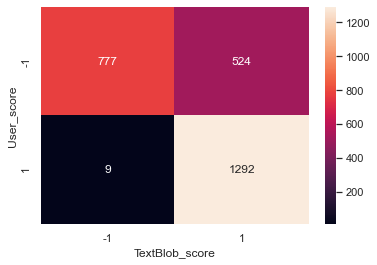

In [47]:
confusion_matrix = pd.crosstab(df['Score'], df['TB_score'], rownames=['User_score'], colnames=['TextBlob_score'])
sns.heatmap(confusion_matrix, annot=True,fmt=".0f")
plt.show()

Noting that the -1 is actually the positive class in this case (i.e. the class we are interested in representing negative reviews) and the +1 is actually the negative class (the class representing good reviews that we are not interested in).

In [50]:
# Metrics function (pos_label = -1 as that represents negative reviews which is the class we are interested in
def metrics(y_true,y_pred):
    a = accuracy_score(y_true, y_pred)*100
    p = precision_score(y_true, y_pred,pos_label = -1)*100
    r = recall_score(y_true, y_pred,pos_label = -1)*100
    f1 = f1_score(y_true, y_pred,pos_label = -1)*100
    roc = roc_auc_score(y_true,y_pred)*100
    
    return a,p,r,f1,roc

In [51]:
metrics(df['Score'], df['TB_score'])

(79.51575710991546,
 98.85496183206108,
 59.72328977709454,
 74.46094873023479,
 79.51575710991544)

## VADER

A compound score greater than and equal to 0.05 is positive and negative is <= 0.05. Neutral is defined by VADER as between -0.05 and 0.05. 

In [52]:
# How many instances are affected by this (ie how many does VADER say are neutral)
df[(df["VComp"]>-0.05) & (df["VComp"]<0.05)].head()

,Town,Category,Score,all_text,Polarity,Subjectivity,VNeg,VNeu,VPos,VComp,TB_score
171,Littlehampton,Food,-1,Mr We were 12 people the table has been booked...,0.037500,0.337500,0.000,1.000,0.000,0.0000,1
292,Littlehampton,Food,-1,"All day breakfast, not The menu states all day...",-0.300000,0.600000,0.000,1.000,0.000,0.0000,-1
330,Arundel,Attractions,1,Coins I prefer to come here for coins to colle...,0.300000,0.533333,0.000,1.000,0.000,0.0000,1
354,Arundel,Accommodation,-1,Sunday lunch Heard the news that this is the p...,-0.083333,0.522222,0.033,0.935,0.032,-0.0129,-1
644,Arundel,Food,-1,"Slow service. Visited earlier in the week, ear...",-0.040972,0.391667,0.000,1.000,0.000,0.0000,-1


Most of these are actually scored as bad reviews by users so we will treat compound scores between -0.05 and +0.05 as negative. Therefore good reviews are compound score of 0.05 and above and bad reviews as compound score of less than 0.05.

In [53]:
# Set polarities greater than equal to 0.05 (majority class) and polarities less than 0.05 to 1 (minority class)
conditions = [(df["VComp"]>=0.05),
              df["VComp"]<0.05]
choices = [1,-1]
df["VComp_score"] = np.select(conditions,choices,default = 'null')
df["VComp_score"] = df["VComp_score"].astype('int32')

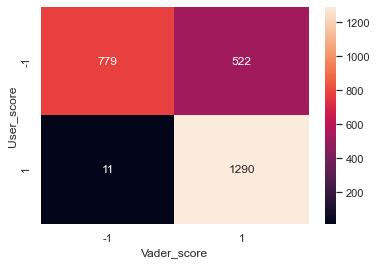

In [54]:
confusion_matrix = pd.crosstab(df['Score'], df['VComp_score'], rownames=['User_score'], colnames=['Vader_score'])
sns.heatmap(confusion_matrix, annot=True,fmt=".0f")
plt.show()

In [55]:
df["VComp_score"].value_counts()

 1    1812
-1     790
Name: VComp_score, dtype: int64

In [56]:
metrics(df['Score'], df['VComp_score'])

(79.51575710991546,
 98.60759493670886,
 59.87701767870869,
 74.50980392156863,
 79.51575710991546)

* Both analysers had very similar metrics with Vader achieving slightly better recall and F1 score
* Neither did as well with the bad reviews, misclassifying many of them as good reviews

## Examination of reviews which VADER got wrong

In [57]:
# Examine some reviews that VADER set as positive but user score was negative
wrong = df[df["Score"] != df["VComp_score"]]
wrong_neg = wrong[wrong["VComp_score"] == 1]
wrong_neg.head(2)

,Town,Category,Score,all_text,Polarity,Subjectivity,VNeg,VNeu,VPos,VComp,TB_score,VComp_score
9,Arundel,Accommodation,-1,Appalling customer service Booked a double roo...,-0.176852,0.375926,0.123,0.751,0.126,0.5255,-1,1
12,Bognor,Accommodation,-1,If you dont want any sleep stay here Do not st...,0.206667,0.500000,0.072,0.799,0.129,0.4753,1,1


In [58]:
wrong_neg.shape

(522, 12)

In [59]:
wrong_neg["all_text"].iloc[0]

'Appalling customer service Booked a double room during August festival, costing £89 no breakfast, had to pay for parking. At no point were we told the band would be playing outside our bedroom in the courtyard with smoke billowing from a wood burner into our room because the window does not shut. On return to our room at 9 pm it was full of smoke and the music was deafening. We complained but the ‘owner’ just kept saying you knew there was a festival on. Yes we did in the surrounding streets but not in our room! Refused to move us or do anything to help resolve the situation. Appalling customer service, bad attitude by the management. Had we been told the band was playing outside our room we would never have booked a room at this hotel.\nRead less'

In [60]:
wrong_neg["all_text"].iloc[1]

"If you dont want any sleep stay here Do not stay in the hotel part above the pub and definitely avoid room 5 as the noise is absolutely horrendous everytime water is used you get woke up, I have stayed in the navigator too part which was fine, breakfast was fine,staff were fine but like i say if you want to sleep this ain't for you"

In [61]:
# Examine some reviews that VADER set as negative but user score was positive
wrong_pos = wrong[wrong["VComp_score"] == -1]
wrong_pos.head(2)

,Town,Category,Score,all_text,Polarity,Subjectivity,VNeg,VNeu,VPos,VComp,TB_score,VComp_score
268,Arundel,Accommodation,1,Enjoyed our first family camping trip! Went fo...,0.227402,0.500588,0.085,0.824,0.091,-0.4833,1,-1
330,Arundel,Attractions,1,Coins I prefer to come here for coins to colle...,0.300000,0.533333,0.000,1.000,0.000,0.0000,1,-1


In [62]:
wrong_pos.shape

(11, 12)

In [63]:
wrong_pos["all_text"].iloc[0]

'Enjoyed our first family camping trip! Went for Friday / Saturday night at the end of May half term (2 kids 5 & 7 years old). Had a really enjoyable time - toilets/showers / sinks really kept well. All off the electricity grid so hot water is off in the middle of the day. Composting toilets but really no different to normal loos.\n\nHad a nice walk through the fields to the worlds end pub.\n\nThere’s a rope swing and slide for the kids (rope swing was too much for my 5 year old).\n\nWe cheated on the weather as only booked when we saw there was no rain!\n\nI could hear the road in the night (no bother for the kids) so if you are a very light sleeper you may want some ear plugs. But 5-stars still fair I think...'

In [64]:
wrong_pos["all_text"].iloc[1]

'Coins I prefer to come here for coins to collect, it’s a long way (an hour by buss) but the coins are all fairly priced and you get a lot of info from the very knowledgeable owner!'

* Vader misclassified more negative reviews as positive than the reverse
* Looking at examples, these appear to be quite long and/or contain mixed sentiments

# Section 5: Relationship VADER polarity and length of review

Does the length of review affect the polarity that VADER gives?

## VADER classed as positive when the user score is negative

In [65]:
# Looking at reviews VADER misclassified as positive when they are scored negative by the user
wrong_neg["Num_tokens"] = wrong_neg["all_text"].apply(lambda x: len(nltk.word_tokenize(x)))

In [66]:
wrong_neg.head()

,Town,Category,Score,all_text,Polarity,Subjectivity,VNeg,VNeu,VPos,VComp,TB_score,VComp_score,Num_tokens
9,Arundel,Accommodation,-1,Appalling customer service Booked a double roo...,-0.176852,0.375926,0.123,0.751,0.126,0.5255,-1,1,153
12,Bognor,Accommodation,-1,If you dont want any sleep stay here Do not st...,0.206667,0.500000,0.072,0.799,0.129,0.4753,1,1,71
20,Arundel,Food,-1,Back to square one Historically this has never...,0.056818,0.456818,0.063,0.847,0.090,0.6248,1,1,192
29,Arundel,Accommodation,-1,ABSOLUTELY FILTHY This was my first and last t...,-0.029431,0.461070,0.087,0.812,0.102,0.8587,-1,1,465
30,Littlehampton,Accommodation,-1,Half Term Break Site Complex not big enough fo...,0.128384,0.461171,0.083,0.777,0.140,0.9830,1,1,404


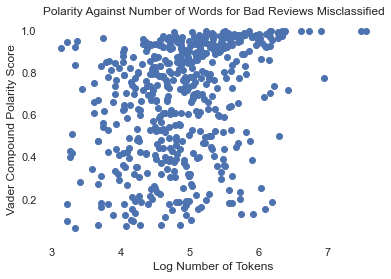

In [67]:
# Plot a scatter plot of the number of tokens and the vader compound polarity score - log used to spread data out
fig, ax = plt.subplots()
ax.set_facecolor("White")
plt.scatter(x = np.log(wrong_neg["Num_tokens"]), y = wrong_neg["VComp"])
plt.xlabel("Log Number of Tokens")
plt.ylabel("Vader Compound Polarity Score")
ax = plt.title("Polarity Against Number of Words for Bad Reviews Misclassified")

In [68]:
# Correlation between the two series
pd.Series.corr(wrong_neg["Num_tokens"],wrong_neg["VComp"])

0.28761602688563237

Seems that the longer the review the more likely VADER is to class it as positive, thereby perhaps missing longer bad reviews

 ## VADER classed as negative when the user score is positive

In [69]:
# Looking at reviews VADER misclassified as negative when they are scored positive by the user
wrong_pos["Num_tokens"] = wrong_pos["all_text"].apply(lambda x: len(nltk.word_tokenize(x)))

In [70]:
wrong_pos.head()

,Town,Category,Score,all_text,Polarity,Subjectivity,VNeg,VNeu,VPos,VComp,TB_score,VComp_score,Num_tokens
268,Arundel,Accommodation,1,Enjoyed our first family camping trip! Went fo...,0.227402,0.500588,0.085,0.824,0.091,-0.4833,1,-1,160
330,Arundel,Attractions,1,Coins I prefer to come here for coins to colle...,0.300000,0.533333,0.000,1.000,0.000,0.0000,1,-1,43
348,Arundel,Accommodation,1,Good value but can be expensive in the height ...,0.097801,0.566435,0.140,0.741,0.119,-0.3045,1,-1,138
434,Bognor,Food,1,Dinner The whole experience was exemplary. The...,-0.013000,0.303000,0.128,0.815,0.057,-0.3818,-1,-1,37
699,Bognor,Food,1,Takeaway Local and really good. First time we...,0.178333,0.481667,0.178,0.767,0.054,-0.7408,1,-1,57


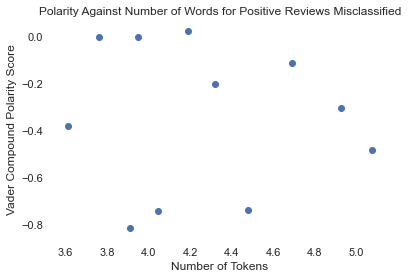

In [71]:
fig, ax = plt.subplots()
ax.set_facecolor("White")
plt.scatter(x = np.log(wrong_pos["Num_tokens"]), y = wrong_pos["VComp"])
plt.xlabel("Number of Tokens")
plt.ylabel("Vader Compound Polarity Score")
ax = plt.title("Polarity Against Number of Words for Positive Reviews Misclassified")

In [72]:
pd.Series.corr(wrong_neg["Num_tokens"], wrong_neg["VComp"])

0.28761602688563237

There are not many points in the scatter plot but there may be a negative correlation between the number of tokens and the Vader score - more likely to give negative score with shorter reviews?

# Section 6: Run VADER with cleaned reviews

In [73]:
df_clean = pd.read_csv("cleanedsampletext.csv",index_col = 0)
df_clean.head(2)

,OrgInd,Town,Category,Score,Review,Review_clean,Pos
0,0,Arundel,Food,1,Very disappointing Three of us ate on a quiet ...,disappointing three u ate quiet night first go...,"[('disappointing', 'JJ'), ('three', 'CD'), ('u..."
1,1,Bognor,Accommodation,0,Amazing place!!! We had a lovely stay at the ...,amazing place lovely stay inklenook room world...,"[('amazing', 'JJ'), ('place', 'NN'), ('lovely'..."


In [74]:
# Put bad reviews as -1 and good reviews as 1
df_clean.Score.replace(1, -1, inplace = True)
df_clean.Score.replace(0, 1, inplace = True)

In [75]:
df_clean = df_clean[["Town","Category","Review_clean","Score"]]

In [76]:
# Run TextBlob against each review in the dataframe
df_clean["Polarity"] = df_clean["Review_clean"].apply(lambda x: TextBlob(x).sentiment.polarity)
df_clean["Subjectivity"] = df_clean["Review_clean"].apply(lambda x: TextBlob(x).sentiment.subjectivity)

In [77]:
# Run VADER against each review in the dataframe
df_clean["VNeg"] = df_clean["Review_clean"].apply(lambda x: sia.polarity_scores(x)['neg'])
df_clean["VNeu"] = df_clean["Review_clean"].apply(lambda x: sia.polarity_scores(x)['neu'])
df_clean["VPos"] = df_clean["Review_clean"].apply(lambda x: sia.polarity_scores(x)['pos'])
df_clean["VComp"] = df_clean["Review_clean"].apply(lambda x: sia.polarity_scores(x)['compound'])

In [78]:
# Set polarities TextBlob
conditions = [(df_clean["Polarity"]>0),df_clean["Polarity"]<=0]
choices = [1,-1]
df_clean["TB_score"] = np.select(conditions,choices,default = 'null')
df_clean["TB_score"] = df_clean["TB_score"].astype('int64')

In [79]:
# Set polarities VADER
conditions = [(df_clean["VComp"]>=0.05),df_clean["VComp"]<0.05]
choices = [1,-1]
df_clean["VComp_score"] = np.select(conditions,choices,default = 'null')
df_clean["VComp_score"] = df_clean["VComp_score"].astype('int32')

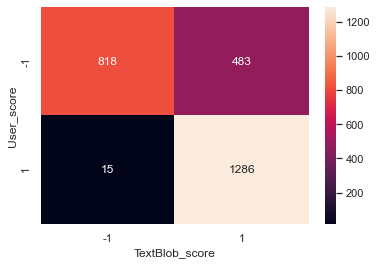

In [80]:
confusion_matrix = pd.crosstab(df_clean['Score'], df_clean['TB_score'], rownames=['User_score'], colnames=['TextBlob_score'])
sns.heatmap(confusion_matrix, annot=True,fmt=".0f")
plt.show()

In [81]:
df_clean["Score"].value_counts()

-1    1301
 1    1301
Name: Score, dtype: int64

In [82]:
metrics(df_clean['Score'], df_clean['TB_score'])

(80.86087624903921,
 98.19927971188476,
 62.874711760184475,
 76.6635426429241,
 80.86087624903921)

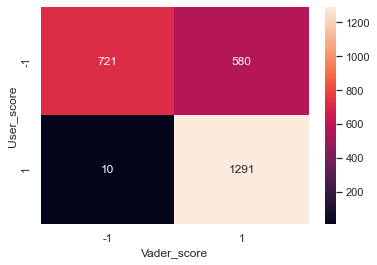

In [83]:
confusion_matrix = pd.crosstab(df_clean['Score'], df_clean['VComp_score'], rownames=['User_score'], colnames=['Vader_score'])
sns.heatmap(confusion_matrix, annot=True,fmt=".0f")
plt.show()

In [84]:
metrics(df_clean['Score'], df_clean['VComp_score'])

(77.32513451191392,
 98.63201094391245,
 55.41890853189854,
 70.96456692913385,
 77.32513451191392)

# Section 7: Summary

Summary

* There appears to be a negative relationship between the length of review and the VADER score.
* For negative reviews misclassified as positive, the longer reviews are more positive 
* There are very few good reviews misclassed as bad reviews.
* Therefore where people write long and negative reviews VADER does not always pick up the negative sentiment and tends to classify the review as positive
* When the data was cleaned, VADER's results generally got worse but TextBlob's improved 
* Recall on both is still fairly low, with the best recall of % on TextBlob with the cleaned text.

The Rules Based Sentiment Analysers achieve good accuracy but recall is poor. They appear to struggle with longer review text when classifying "Bad" reviews. They do not appear to account for context well in these cases. 